In [3]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

np.random.seed(42)

# Macroparams

In [46]:
material_name = 'Steel, 1% carbon'
alpha = 1.172e-5  # thermal diffusivity [m^2/s], (steel, 1% carbon)
Lx, Ly = 0.1, 0.1  # length [m]
nx, ny = 40, 40  # points [unitless]
dt = 0.1  # delta time [s]
ft = 10  # simulation time [s]

BC1, BC2 = 150, 0  # Bounday conditions (Dirichlet) [K], BC1 - temperature inside region, BC2 - temperature on edge

# Convergence check

In [11]:
dx, dy = Lx / nx, Ly / ny
nt = int(ft / dt)

Cx, Cy = alpha*dt/(dx**2), alpha*dt/(dy**2) #  Courant–Friedrichs–Lewi convergence condition
if Cx > 0.5 or Cy > 0.5:  # L1 norm
    warnings.warn("CFL > 1, equations with this macroparams does not converges")

# Solution

$\frac{\partial u}{\partial t}(\mathbb{x}, t) = \alpha\Delta u + f(\mathbb{x}, t)$, where  
$f(\mathbb{x}, t)$ - external forces  
$\alpha$ - thermal diffusivity

**Solve method**: RK4

$u_t(\mathbb{x}) = T$  
$u_{t+1}(\mathbb{x}) = T + (\alpha \operatorname{div} \operatorname{grad} u(\mathbb{x}) + F_t(\mathbb{x}))dt$  
$ \frac{du}{dt} = \Delta u + F(\mathbb{x}) $  
Assume $F(\mathbb{x}) \equiv 0$
 


In [69]:
def external(t, i, j):
    if i == 20 and j == 10:
        return 100
    if i == 20 and j == 30:
        return -100
    return 0

In [70]:
F = np.zeros((nt, nx, ny))
# for i in range(0, nx):
#     for j in range(0, ny):
#         F[0, i, j] = 300 if (i-nx/2)**2 + (j-ny/2)**2 < min(nx, ny)**2 / 16 else 0
for i in range(0, nx):
    for j in range(0, ny):
        F[0, i, j] = 300 if nx/4 <= i <= 3*nx/4 and ny/4 <= j <= 3*ny/4 else 0
for i in range(0, nx):
    F[0, i, 0] = F[0, i, -1] = BC2
for j in range(0, ny):
    F[0, 0, j] = F[0, -1, j] = BC2

Euler's method

In [71]:
for t in range(nt-1):
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            d2udx2 = (F[t, i+1, j] - 2*F[t, i, j] + F[t, i-1, j]) / dx**2
            d2udy2 = (F[t, i, j+1] - 2*F[t, i, j] + F[t, i, j-1]) / dy**2
            F[t+1, i, j] = alpha*(d2udx2 + d2udy2) * dt + F[t, i, j] + external(t, i, j) # + external forces F(x, t)

RK4

In [44]:
def f(F, i, j, t):
    d2udx2 = (F[i+1, j] - 2*F[i, j] + F[i-1, j]) / dx**2
    d2udy2 = (F[i, j+1] - 2*F[i, j] + F[i, j-1]) / dy**2
    return alpha*(d2udx2 + d2udy2)  # + external forces F(x, t)

for t in range(nt-1):
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            Ft = F[t, :, :]
            k1 = f(Ft, i, j, t)
            k2 = f(Ft + k1*dt/2, i, j, t + dt/2)
            k3 = f(Ft + k2*dt/2, i, j, t + dt/2)
            k4 = f(Ft + k3*dt, i, j, t + dt)
            F[t+1, i, j] = F[t, i, j] + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6

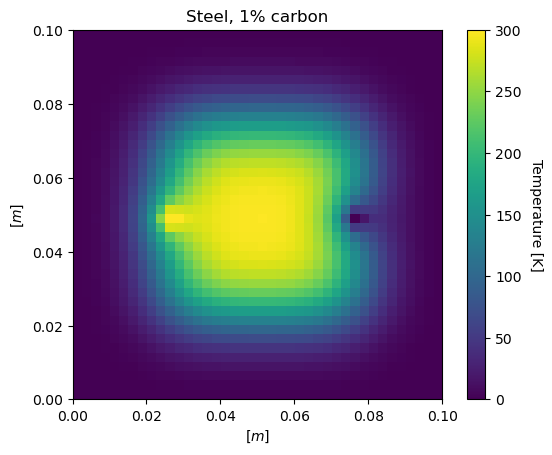

In [72]:
fig, ax1 = plt.subplots(1, 1)

im = ax1.imshow(F[0, :, :], animated=True, extent=[0,Lx,0,Ly])
ax1.set_title(material_name)
ax1.set_xlabel('[$m$]')
ax1.set_ylabel('[$m$]')


cb = plt.colorbar(im)
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('Temperature [K]', rotation=270)

i = 0
def update(*args):
    global i
    if i < F.shape[0]:
        i += 1
    else:
        i = 0
    im.set_array(F[i, :, :])
    return im,

anim = animation.FuncAnimation(fig, update, frames=30, interval=1000/30)#,  blit=True)
writervideo = animation.FFMpegWriter(fps=30)
anim.save("anim.mp4", writer=writervideo)
plt.show()